# Download and extract dataset

In [ ]:
#@title Download a the dataset sample from Supervisely
!curl https://assets.supervisely.com/supervisely-supervisely-assets-public/teams_storage/W/6/pt/ANAGVgKaC62tTrDQWK5JhNP2dd8ynqaTKSM1QdVoAasmTdaLvBwCuW7nCrq9o9lLS2padKnV9QogVGFlEPg7vxEBPIfuFC2Yq7ELNW7xn2t1egLrQPoGpNFJobhh.tar --output mvtec.tar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  548M  100  548M    0     0  26.9M      0  0:00:20  0:00:20 --:--:-- 28.8M


In [ ]:
#@title Extract the tarball 'mvtec.tar' and look for test images for the hazelnut subset
!tar -xf mvtec.tar
!ls test/img/hazelnut_*

tar: Removing leading `/' from member names
test/img/hazelnut_crack_002.png  test/img/hazelnut_print_004.png
test/img/hazelnut_cut_003.png	 test/img/hazelnut_print_005.png
test/img/hazelnut_good_023.png	 test/img/hazelnut_print_006.png
test/img/hazelnut_good_037.png	 test/img/hazelnut_print_007.png
test/img/hazelnut_hole_005.png	 test/img/hazelnut_print_009.png
test/img/hazelnut_hole_010.png	 test/img/hazelnut_print_011.png
test/img/hazelnut_hole_013.png	 test/img/hazelnut_print_012.png
test/img/hazelnut_hole_016.png	 test/img/hazelnut_print_013.png
test/img/hazelnut_print_003.png  test/img/hazelnut_print_016.png


In [ ]:
#@title Configure git user
!git config --global user.email "akashpotti06@gmail.com"
!git config --global user.name "Akash Potti"

In [ ]:
%cd /content/ZS-CLIP-AC-naive

/content/ZS-CLIP-AC-naive


In [ ]:
#@title TO DO: Checkout the EXISTING feature branch in the repository. What's it called? How do you find the names of existing branches?
# DO NOT create a new branch!
#list all branches
print("Branches: ")
!git branch -a
!git checkout feature/template-code

Branches: 
* main
  remotes/origin/HEAD -> origin/main
  remotes/origin/feature/template-code
  remotes/origin/main
Branch 'feature/template-code' set up to track remote branch 'feature/template-code' from 'origin'.
Switched to a new branch 'feature/template-code'


In [ ]:
#@title Verify that the files appear here
!ls

clip_ac.py  data  README.md  requirements.txt  spec.py


In [ ]:
#@title Move images for the hazelnut subset from the test split to the `data` folder in the repository
!cp /content/test/img/hazelnut_* data/

In [ ]:
#@title Install the requirements from the `requirements.txt` file
!pip install -qr requirements.txt

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.1 MB/s eta 0:00:00


Class distribution: Counter({'print': 10, 'hole': 4, 'good': 2, 'cut': 1, 'crack': 1})
Image size min: [1024 1024]
Image size max: [1024 1024]
Unique sizes: 1


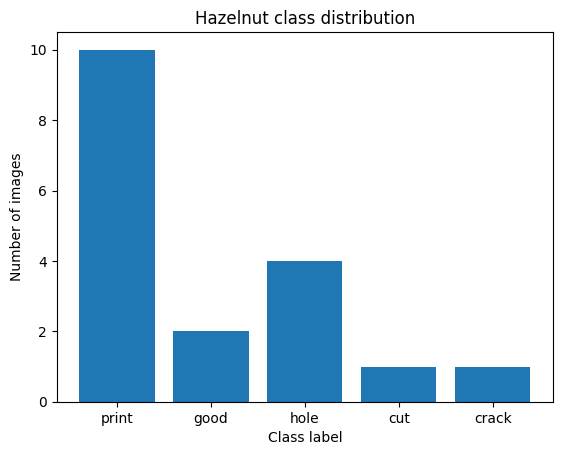

In [ ]:
# This block inspects the dataset structure before running CLIP.
# It checks:
#   1. Class distribution (how many hazelnuts per defect type)
#   2. Image sizes (consistency across dataset)
#   3. A simple bar chart of class counts

from pathlib import Path
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random

# Define path to dataset
data_dir = Path("data")

# Collect all hazelnut image files (named like hazelnut_<class>.png)
files = list(data_dir.glob("hazelnut_*.png"))

# Extract labels from filenames (e.g., hazelnut_good.png → "good")
labels = [f.stem.split("_")[1] for f in files]

# Count number of images per class
counts = Counter(labels)
print("Class distribution:", counts)

# Check image dimensions for consistency
sizes = [Image.open(f).size for f in files]   # list of (width, height)
arr = np.array(sizes)
print("Image size min:", arr.min(axis=0))     # smallest (w,h) across dataset
print("Image size max:", arr.max(axis=0))     # largest (w,h) across dataset
print("Unique sizes:", len(set(sizes)))       # number of distinct resolutions

# Plot histogram of class distribution
plt.bar(counts.keys(), counts.values())
plt.title("Hazelnut class distribution")
plt.xlabel("Class label")
plt.ylabel("Number of images")
plt.show()

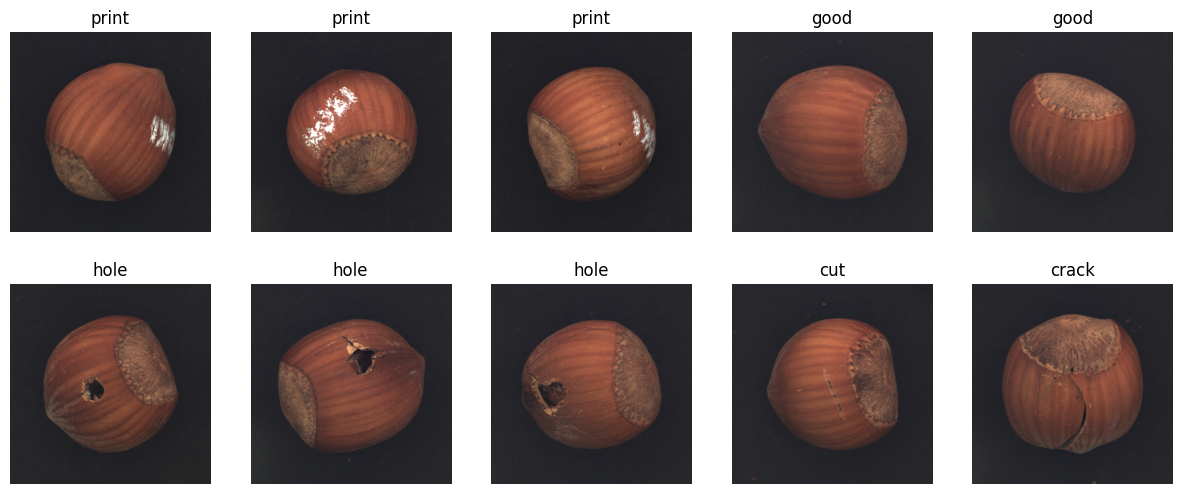

In [ ]:
sampled = []
for cls in counts.keys():
    cls_files = [f for f in files if f.stem.split("_")[1] == cls]
    sampled.extend(random.sample(cls_files, min(3, len(cls_files))))

fig, axs = plt.subplots(2, len(sampled)//2, figsize=(15,6))
for ax, f in zip(axs.flatten(), sampled):
    img = Image.open(f)
    ax.imshow(img)
    ax.set_title(f.stem.split("_")[1])
    ax.axis("off")
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Implementation

Go through the [CLIP github repo](https://github.com/openai/CLIP) to understand zero-shot classification. Go through section 4.1 in the [WinCLIP paper](https://arxiv.org/abs/2303.14814) to understand zero-shot anomaly classification; they call this `CLIP-AC`.

Your task is to extend anomaly classification (just normal vs defective) to do defect classification (normal vs different categories of defects) using the CLIP model.

Your model should predict non-defective images as "good". For defective images, the defect category should be predicted as the class name. See the image filenames to know the defect categories; or see the [MVTec-AD dataset details](https://openaccess.thecvf.com/content_CVPR_2019/papers/Bergmann_MVTec_AD_--_A_Comprehensive_Real-World_Dataset_for_Unsupervised_Anomaly_CVPR_2019_paper.pdf). This task is only for the `hazelnut` subset.

Note that the 'clip' package from OpenAI is installed as part of the requirements in the previous cell.

In [ ]:
#@title TO DO: Modify `spec.py` and save its contents
%%writefile spec.py
"""
Spec containing the configuration for the defect classification task
"""

from pydantic import BaseModel
from typing import List


class DefectClassificationSpec(BaseModel):
    """
    Configuration for defect classification.

    Attributes:
        class_names (List[str]): The list of class names (normal + defect categories).
        prompts (List[List[str]]): List of textual prompts per class.
            - Example: [["a photo of a good hazelnut"], ["a photo of a hazelnut with a crack"], ...]
        model_name (str): Name of the CLIP model variant to use (default: ViT-B/16).
        support_images (List[List[str]]): Optional support images per class.
            - Each inner list contains file paths for that class.
            - Used for few-shot prototype construction.
    """

    # List of class labels
    class_names: List[str]

    # List of prompt lists, aligned with class_names
    prompts: List[List[str]]

    # CLIP model variant (default = ViT-B/16)
    model_name: str = "ViT-B/16"

    # Few-shot support image paths (default = empty lists).
    support_images: List[List[str]] = []

Overwriting spec.py


In [ ]:
import importlib
import spec

# Reload spec module to pick up the latest changes
importlib.reload(spec)

from spec import DefectClassificationSpec

# Print the type annotations of the Spec class
print(DefectClassificationSpec.__annotations__)

{'class_names': typing.List[str], 'prompts': typing.List[typing.List[str]], 'model_name': <class 'str'>, 'support_images': typing.List[typing.List[str]]}


In [ ]:
#@title TO DO: Modify `clip_ac.py` and save its contents
%%writefile clip_ac.py
"""
Zero-shot (or few-shot) defect classification using CLIP.

This script:
  - Builds class prototypes from prompts (+ optional support images)
  - Encodes test images with CLIP
  - Classifies each test image based on cosine similarity to prototypes
"""

import clip
import torch
from PIL import Image
from pathlib import Path
from typing import List, Tuple
from spec import DefectClassificationSpec


def _parse_label_from_filename(p: Path) -> str:
    """
    Extract the class label from a filename.
    Expected filename format: hazelnut_<class>_<id>.png

    Args:
        p (Path): Path to image file.

    Returns:
        str: The extracted class label, or "unknown" if format does not match.
    """
    stem = p.stem
    parts = stem.split("_")
    if len(parts) >= 3 and parts[0] == "hazelnut":
        return parts[1]
    return "unknown"


def classify_defects(spec: DefectClassificationSpec, test_dir: Path) -> Tuple[List[str], List[str]]:
    """
    Perform defect classification using CLIP.

    Args:
        spec (DefectClassificationSpec): Specification with class names, prompts, model, and support images.
        test_dir (Path): Directory containing test hazelnut images.

    Returns:
        Tuple[List[str], List[str]]:
            - y_true: Ground truth labels
            - y_pred: Predicted labels
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load(spec.model_name, device=device)

    # ---- Step 1: Build class prototypes ----
    with torch.no_grad():
        class_prototypes = []
        for i, prompt_group in enumerate(spec.prompts):
            # --- Encode text prompts ---
            text_tokens = clip.tokenize(prompt_group).to(device)
            text_feats = model.encode_text(text_tokens)
            text_feats = text_feats / text_feats.norm(dim=-1, keepdim=True)  # normalize embeddings
            text_mean = text_feats.mean(dim=0)  # average across prompts

            # --- Encode support images (if provided) ---
            img_feats = []
            if i < len(spec.support_images):
                for img_path in spec.support_images[i]:
                    img = Image.open(img_path).convert("RGB")
                    img = preprocess(img).unsqueeze(0).to(device)
                    feat = model.encode_image(img)
                    feat = feat / feat.norm(dim=-1, keepdim=True)
                    img_feats.append(feat.squeeze(0))

            # Combine text and image prototypes
            if img_feats:
                img_mean = torch.stack(img_feats).mean(dim=0)
                prototype = (0.5 * text_mean + 0.5 * img_mean)  # equal weighting
            else:
                prototype = text_mean

            # Normalize final prototype
            prototype = prototype / prototype.norm()
            class_prototypes.append(prototype)

        # Stack all prototypes into one tensor
        class_prototypes = torch.stack(class_prototypes)

    # ---- Step 2: Classify test images ----
    y_true, y_pred = [], []

    for p in sorted(test_dir.glob("hazelnut_*.png")):
        gt = _parse_label_from_filename(p)
        if gt not in spec.class_names:
            continue

        # Preprocess test image
        img = Image.open(p).convert("RGB")
        img = preprocess(img).unsqueeze(0).to(device)

        with torch.no_grad():
            img_feat = model.encode_image(img)
            img_feat = img_feat / img_feat.norm(dim=-1, keepdim=True)

        # Compute similarity against prototypes.
        logits = img_feat @ class_prototypes.T
        pred = logits.argmax(dim=-1).item()

        y_true.append(gt)
        y_pred.append(spec.class_names[pred])

    return y_true, y_pred

Overwriting clip_ac.py


In [ ]:
# %reset -f clears all variables, functions, imports, etc.
# (force = True means no confirmation prompt)
%reset -f

# Reload clip_ac after modifications
import importlib
import clip_ac

# Ensure latest version of clip_ac is loaded into memory
importlib.reload(clip_ac)

<module 'clip_ac' from '/content/ZS-CLIP-AC-naive/clip_ac.py'>

In [ ]:
# ------------------------------
# Run defect classification
# ------------------------------

from spec import DefectClassificationSpec
from clip_ac import classify_defects
from pathlib import Path

# Define your classes
class_names = ["print", "hole", "good", "crack", "cut"]

# Define natural-language prompts for each class
# Each sublist corresponds to one class
prompts = [
    [  # print
        "a close-up photo of a hazelnut with a print defect on its shell",
        "a hazelnut showing stains or printed marks on its surface",
        "a hazelnut with surface print imperfections",
        "industrial inspection photo of a hazelnut with ink stains",
        "a hazelnut shell with visible letters or symbols printed on it",
        "a hazelnut surface marked with artificial prints",
        "a defect where the hazelnut shows abnormal surface printing",
        "macro photo of a hazelnut showing unwanted print marks",
        "hazelnut with man-made markings on the shell",
        "a nut inspection image showing a print defect"
    ],
    [  # hole
        "a close-up photo of a hazelnut with a hole in its shell",
        "a hazelnut showing a hollow spot on its surface",
        "a hazelnut with a drilled hole defect",
        "macro photo of a hazelnut damaged with a cavity",
        "hazelnut with a puncture visible on the shell",
        "industrial inspection photo of a hazelnut with a hole",
        "a hazelnut shell showing a round opening defect",
        "damaged hazelnut with a hollow defect",
        "a nut with a visible cavity in the shell",
        "hazelnut with structural damage caused by a hole"
    ],
    [  # good
        "a hazelnut with no cracks, holes, cuts, or prints",
        "a flawless hazelnut free from any defects",
        "a quality control photo of a defect-free hazelnut",
        "an intact hazelnut without surface damage",
        "a good hazelnut that does not have any imperfections"
    ],
    [  # crack
        "a close-up photo of a hazelnut with a crack on its shell",
        "a hazelnut showing a broken shell with visible cracks",
        "a damaged hazelnut with crack lines",
        "macro photo of a hazelnut shell split with a crack",
        "hazelnut showing fracture lines on its surface",
        "a nut with cracked shell damage",
        "industrial inspection photo of a cracked hazelnut",
        "hazelnut with deep structural cracks on the shell",
        "a shell defect where the hazelnut surface is split",
        "hazelnut with visible crack running along the shell"
    ],
    [  # cut
        "a close-up photo of a hazelnut with a cut defect on its shell",
        "a hazelnut that has been sliced open",
        "a hazelnut shell with a sharp cut defect",
        "macro photo of a hazelnut showing cut marks",
        "hazelnut surface sliced with a sharp tool",
        "industrial inspection image of a hazelnut cut",
        "a nut shell with a visible slice defect",
        "hazelnut damaged by a cut along its shell",
        "a shell defect caused by slicing the hazelnut",
        "photo of a hazelnut with a clean cut mark",
        "a hazelnut shell with a straight cut line from a blade",
    ]
]

# Define support images
support_images = [
    ["data/hazelnut_print_004.png", "data/hazelnut_print_005.png"],   # print
    ["data/hazelnut_hole_005.png", "data/hazelnut_hole_010.png"],     # hole
    ["data/hazelnut_good_023.png", "data/hazelnut_good_037.png"],     # good
    ["data/hazelnut_crack_002.png"],                                  # crack
    ["data/hazelnut_cut_003.png"]                                     # cut
]

# Create the spec object
spec = DefectClassificationSpec(
    class_names=class_names,
    prompts=prompts,
    support_images=support_images
)

# Run classification
y_true, y_pred = classify_defects(spec, Path("data"))

# Inspect results
print("Samples:", len(y_true))                       # total number of test samples
print("First few:", list(zip(y_true, y_pred))[:10])  # peek at first predictions.
#print("Model used:", spec.model_name)                # confirm which CLIP variant was used.

100%|███████████████████████████████████████| 335M/335M [00:06<00:00, 53.9MiB/s]


Samples: 18
First few: [('crack', 'crack'), ('cut', 'cut'), ('good', 'good'), ('good', 'good'), ('hole', 'hole'), ('hole', 'hole'), ('hole', 'hole'), ('hole', 'cut'), ('print', 'print'), ('print', 'print')]


[[9 0 0 0 1]
 [0 3 0 0 1]
 [0 0 2 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]]
Overall accuracy: 88.889%

Per-class metrics:
print: TP=9, FP=0, TN=8, FN=1
hole: TP=3, FP=0, TN=14, FN=1
good: TP=2, FP=0, TN=16, FN=0
crack: TP=1, FP=0, TN=17, FN=0
cut: TP=1, FP=2, TN=15, FN=0


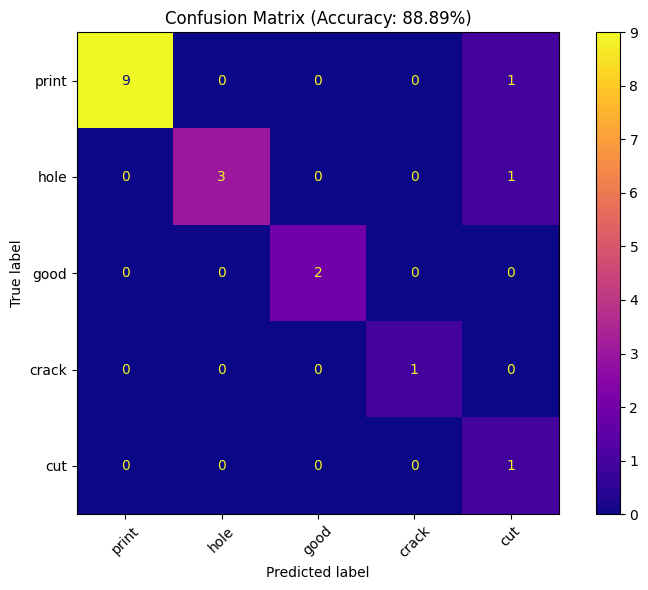

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

labels = spec.class_names
cm = confusion_matrix(y_true, y_pred, labels=labels)
print(cm)
# Overall accuracy
acc = cm.diagonal().sum() / cm.sum() * 100
print(f"Overall accuracy: {acc:.3f}%")

# Compute TP, FP, TN, FN per class
print("\nPer-class metrics:")
for i, label in enumerate(labels):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    print(f"{label}: TP={TP}, FP={FP}, TN={TN}, FN={FN}")

# --- Plotting ---
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax, cmap="plasma", colorbar=True, values_format="d")

plt.title(f"Confusion Matrix (Accuracy: {acc:.2f}%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Observations (TO DO)

Final classifier reached overall accuracy of 88.89%.

Classwise analysis

*   **Print:** 90% recall indicates high confidence
*   **Hole:** 75% recall also indicates hight confidence
*   **Good:** Achieved perfect classification with 0 FN AND FP
*   **Hole:** Achieved perfect classification with 0 FN AND FP
*   **Cut:** Single TP was correctly classified the model produced 2 FP. This issue is mostly arises from few test samples for cut and visual simlarity between cut and crack.

**Support images were critical**
Blending text and support embeddings at a 0.5 : 0.5 weight produced the best results of approx 89%.


**Future Improvements**

Despite experimenting with different classification specs (prompt variants, weight adjustments, and prompt ensembling), the model consistently converged around ~89% accuracy. Most classes are stable, with misclassifications concentrated in the “cut” class. This indicates that the performance ceiling is due to dataset limitations (few, ambiguous samples) rather than classifier specification. Future improvements will likely require more support data, stronger backbones, or light fine-tuning rather than further spec adjustment